<a href="https://colab.research.google.com/github/LinarKulinar/VortexBeamResearch/blob/main/forming_vortex_beam_master_research_2022_forming_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Вихревые оптические пучки**
## **НИР Ахметов Линар 6133 2 семестр магистратуры**
### Тема НИР: Распознавание мультиплексированных вихревых пучков с использованием нейронных сетей



### **Описание ноутбука и полученные выводы**

Реализован код, создающий датасет из пучков (являющихся суперпозицией двух пучков с угловыми орбитальными моментами разных знаков из диапазона [-5,-1] и [1,5] соответственно) (в качестве метки использовался модуль разности двух угловых орбитальных моментов)

Полученные 30 изображений пучков были подвергнуты аугментации сдвигом и вращением, что дало нам 33750 различных изображений принадлежащих различным 10 классам.

Полученыые 33750 изображений были скормлены нейронной сети на tensorflow с двумя Dense слоями.

На обучающей и тестовой выборке была достигнута accuracy в 0.93

Визуализированы результаты предсказаний.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

Определим функцию *f*, которая задает значение поля в точке *(r, phi)* с учётом параметров *m∈ℤ* и σ∈ℜ.:

$ f(r, ϕ) = exp(-\cfrac{r^2}{σ^2}) \cdot r^{|m|} \cdot exp(i \cdot m \cdot ϕ) $

Сразу же и пропустим пучок через наклоненную линзу. В некотором приближении это преоразованияе описывает формула ниже:


$ tilt(r, ϕ) = exp(i \cdot α \cdot x \cdot y) $,

где $α$-малый угол наклона линзы

In [2]:
def f_with_tilt (r, phi, m, sigma, alpha):
    """
    Функция, описывающая входной вихревой пучок, который пропустили через наклоненную линзу. 
    :param r: удаление точки от центра изображения
    :param phi: угол точки в исходном пучке
    :param m: параметр пучка - угловой орбительный момент
    :param sigma: параметр пучка - радиус перетяжки
    :param alpha: параметр линзы, сквозь который проходит пучок - угол (в радианах) отклонения оси линзы от линии распространения пучка
    :return значение функции в точке (r, phi)
    """
    assert abs(alpha) <= 0.7 # т.к. предельный угол полного отражения на границе среды воздух-стекло равен 37 градусов. А вообще вроде угол должен быть прям совсем малым (по предположениям, которые позволяют юзать формулу измненеия поля при пропускании через наклюненную линзу)
    x = r*math.cos(phi)
    y = r*math.sin(phi)  
    return math.exp(-(r/sigma)**2) * r**abs(m) * (math.cos(m * phi) + math.sin(m * phi)*1j) * (math.cos(alpha * x * y) + math.sin(alpha * x * y)*1j)

Определим функцию, создающую и вычисляющую значение функции *f(r, ϕ)* в каждой точке квадратного поля размером *(-size, size)*  с числом отсчётов, переданных в кортеже *matrix_shape*

In [3]:
def get_field_with_tilt_and_control_size(image_size, vertex_size, matrix_shape, m, sigma, alpha):
    """
    Создаёт и вычисляет значение функции f(r, ϕ) в каждой точке квадратного поля размером (-size, size) с числом отсчётов, переданных в кортеже matrix_shape
    """
    assert len(matrix_shape) == 2
    assert matrix_shape[0] % 2 == 1
    assert matrix_shape[1] % 2 == 1
    
    x_linspace = np.linspace(-image_size, image_size, matrix_shape[0])
    y_linspace = np.linspace(-image_size, image_size, matrix_shape[1]) 
    field = np.zeros(matrix_shape, dtype=complex)

    for i in range(matrix_shape[0]):
        for j in range(matrix_shape[1]):
            middle = min(matrix_shape) // 2
            di = i - middle
            dj = j - middle
            if abs(di) ** 2 + abs(dj) ** 2 <= middle ** 2:  # Если мы находимся внутри круга с радиусом, равным count/2
                phi = math.atan2(di, dj) # в полярных координатах
                r_coord = math.sqrt(x_linspace[i]**2 + y_linspace[j]**2)
                field[i,j] = f_with_tilt (r_coord, phi, m, sigma, alpha)
    return (field, x_linspace, y_linspace)

Определим функцию, формирующую изображения пучков из комплексного numpy-массива field

In [4]:
def plot_field(field, x_linspace, y_linspace, print_mode=["amplitude", "intensity", "phase"]):
    """
    Функция отрисовывающая комплексное поле field. Масшабы по осям изображения определяются 
    :param field: Комплексное двумерное поле
    :param x_linspace: Масштаб на изображении по оси x определяется этим linspace
    :param y_linspace: Масштаб на изображении по оси x определяется этим linspace
    :param print_mode: Список, позволяет указать необходимые рисунки с помощью этого параметра из списка ["amplitude", "intensity", "phase"]
    :return значение функции в точке (r, phi)
    """
    import matplotlib.cm as cmap
    extent = [np.max(y_linspace), np.min(y_linspace), np.min(x_linspace), np.max(x_linspace)] # для корректных чисел на осях графика
    factor_for_colorbar = 15 / 12 # сраная магия подбора для matplotlib
    height_of_image = 6 # константа, пропорциональная высоте картинки
    
    if ("amplitude" in print_mode):
        plt.figure(figsize=(factor_for_colorbar * height_of_image * field.shape[1]/field.shape[0], height_of_image))
        #plt.figure(figsize=(7.5, 6)) # только для квадратных картинок
        plt.imshow(np.absolute(field), cmap=cmap.hot, aspect='auto', extent=extent)
        plt.title("Амплитуда комплексного поля")
        plt.ylabel('y, расстояние (см)')
        plt.xlabel('x, расстояние (см)')
        plt.grid(True)
        plt.colorbar()
        #plt.savefig("num_i="+str(num_i)+" num_m="+str(num_m)+"/Распредление по радиусу во время 0,5t")
        plt.show()

    if ("intensity" in print_mode):
        plt.figure(figsize=(factor_for_colorbar * height_of_image * field.shape[1]/field.shape[0], height_of_image))
        plt.imshow(np.absolute(field)**2, cmap=cmap.hot, aspect='auto', extent=extent)
        plt.title("Интенсивность комплексного поля")
        plt.ylabel('y, расстояние (см)')
        plt.xlabel('x, расстояние (см)')
        plt.grid(True)
        plt.colorbar()
        #plt.savefig("num_i="+str(num_i)+" num_m="+str(num_m)+"/Распредление по радиусу во время 0,5t")
        plt.show()
    if ("phase" in print_mode):
        plt.figure(figsize=(factor_for_colorbar * height_of_image * field.shape[1]/field.shape[0], height_of_image))
        plt.imshow(np.angle(field), cmap=cmap.hot, aspect='auto', extent=extent)
        plt.title("Фаза комплексного поля")
        plt.ylabel('y, расстояние (см)')
        plt.xlabel('x, расстояние (см)')
        plt.grid(True)
        plt.colorbar()
        #plt.savefig("num_i="+str(num_i)+" num_m="+str(num_m)+"/Распредление по радиусу во время 0,5t")
        plt.show()

Вызовем вышеописанные функции для отображения пучка *m = 3* и числом отчётов, равным *101* по горизонтали и вертикали 

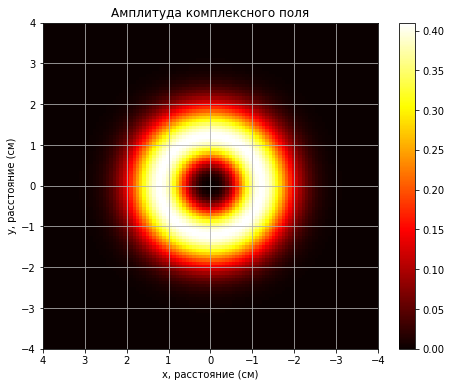

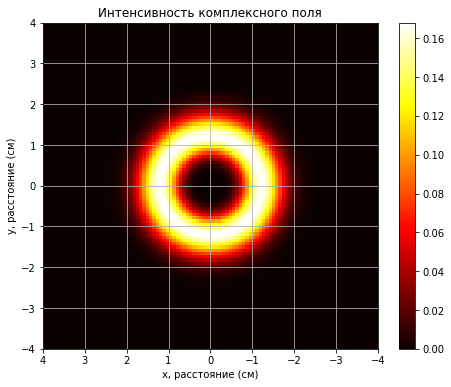

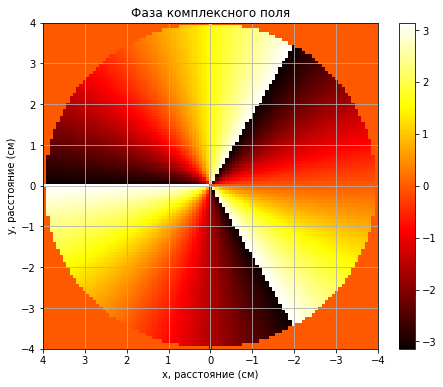

In [5]:
field, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=4, vertex_size=1, matrix_shape=(101, 101), m=3, sigma=1, alpha=0)
plot_field(field, x_linspace, y_linspace)

### Определим функцию, которая дополняет нулями исходную картинку:

In [6]:
def get_field_padded_zeros(field, new_shape, x_linspace, y_linspace):
    """
    Дополняет двухмерное изображение нулями до размера new_shape, если new_shape больше размера картини. Обрезает изображение до размера new_shape, если new_shape меньше размера картинки.
    Если по одной оси надо обрезать, а по второй дополнить нулями, выкинется ValueError
    :param field: изображение
    :param new_shape: новые размеры изображения
    :param x_linspace: размеры входного изображения (в см/м/мм)
    :param y_linspace: размеры входного изображения (в см/м/мм)
    """
    assert len(field.shape) == 2
    assert field.shape[0] % 2 == 1
    assert field.shape[1] % 2 == 1
    
    assert len(new_shape) == 2
    assert new_shape[0] % 2 == 1
    assert new_shape[1] % 2 == 1
    
    field_padded_zeros = np.zeros(new_shape, dtype=field.dtype)
    #print(field_padded_zeros)
    
    diff0dimetional=(new_shape[0]-field.shape[0])//2
    #print("diff0dimetional =",diff0dimetional)
    diff1dimetional=(new_shape[1]-field.shape[1])//2
    #print("diff1dimetional =",diff1dimetional)
    
    if (diff0dimetional >= 0 and diff1dimetional >= 0):  
        #print("slicesindex=[",diff0dimetional, ":", new_shape[0]-diff0dimetional, ",", diff1dimetional, ":", new_shape[1]-diff1dimetional,"]")
        field_padded_zeros[diff0dimetional : new_shape[0]-diff0dimetional, diff1dimetional : new_shape[1]-diff1dimetional] = field
    else:
        if (diff0dimetional <= 0 and diff1dimetional <= 0):
            #print("slicesindex=[",-diff0dimetional, ":", field.shape[0]+diff0dimetional, ",", -diff1dimetional, ":", field.shape[1]+diff1dimetional,"]")
            field_padded_zeros = field[-diff0dimetional : field.shape[0]+diff0dimetional, -diff1dimetional : field.shape[1]+diff1dimetional]
        else:
            raise ValueError("Код не предусматривает, что необходимо дополнять нулями по одной оси и обрезать по другой. Реализация подразумевает, что можно либо дополнять нулями либо обрезать")
    #пересчитываем linspace:
    x_linspace_padded_zeros = x_linspace / field.shape[0] * new_shape[0]
    y_linspace_padded_zeros = y_linspace / field.shape[1] * new_shape[1]
    return (field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)
    
# For tests
# get_field_padded_zeros(np.array([[4]]), (7,7), np.array([-1,1]), np.array([-2,2]))
# get_field_padded_zeros(np.array([[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4],[5,5,5,5,5]]), (7,5), np.array([-1,1]), np.array([-2,2]))

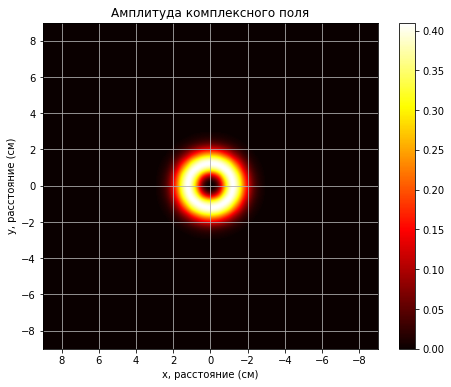

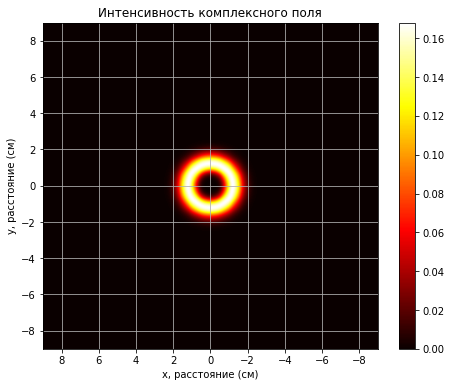

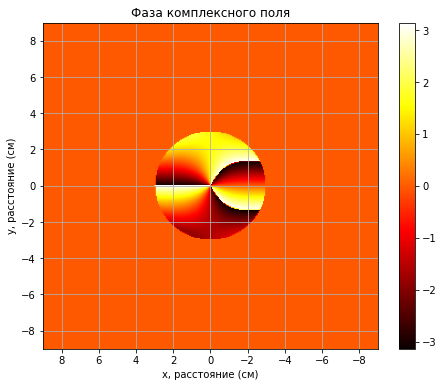

In [7]:
field, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=3, vertex_size=1, matrix_shape=(101, 101), m=3, sigma=1, alpha=0.5)
field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros = get_field_padded_zeros(field, (303, 303), x_linspace, y_linspace)
plot_field(field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)

### Тестовый код, который выполняет FFT над вихревым полем

In [8]:
# # Параметры, с которыми будет выполняться код
# a=3 # Размер исходного поля
# N=101 # Число отсчётов картинки, поле которой мы генерируем
# M=505 # Число отсчётов, до которого дополняем поле до fft2
# b=N*N/4/a/M # Размер выходного поля после fft2 (с допущением, что длина волны обратно пропорциональна фокусному расстоянию)
# print("Размер выходного поля b =",b)

# # Генерируем поле лазера
# field, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=a, vertex_size=a, matrix_shape=(N, N), m=2, sigma=1, alpha=0.5)
# field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros = get_field_padded_zeros(field, (M, M), x_linspace, y_linspace)
# # Отприсовываем получившееся поле 
# #plot_field(field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)

# # Выполняем fft2 преобразование (+ расщитываем масштаб)
# field_after_fft = np.fft.fft2(field_padded_zeros)
# field_after_fft = np.fft.fftshift(field_after_fft)
# # Отрезаем поле размером NxN
# field_after_fft = get_field_padded_zeros(field_after_fft, (N, N), x_linspace, y_linspace)[0]
# # Перерасчитываем масштаб поля после fft 
# x_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[0])
# y_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[1])
# # Отрисовываем картинки после fft2
# plot_field(field_after_fft, x_linspace_after_fft, y_linspace_after_fft)

### Определим функцию, которая выдает картинку после fft

In [9]:
# def get_field_after_tilt_and_fft(a, N, M, m, sigma, alpha):
#     """
#     Дополняет двухмерное изображение нулями до размера new_shape, если new_shape больше размера картини. Обрезает изображение до размера new_shape, если new_shape меньше размера картинки.
#     Если по одной оси надо обрезать, а по второй дополнить нулями, выкинется ValueError
#     :param a: Размер исходного поля
#     :param N: Число отсчётов картинки, поле которой мы генерируем
#     :param M: Число отсчётов, до которого дополняем поле до fft2
#     :param m: параметр пучка - угловой орбительный момент
#     :param sigma: параметр пучка - радиус перетяжки
#     :param alpha: параметр линзы, сквозь который проходит пучок - угол (в радианах) отклонения оси линзы от линии распространения пучка
#     :return ((field, x_linspace, y_linspace),(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2))
#     """
#     b=N*N/4/a/M # 
#     print("Размер выходного поля b =",b)
 
#     # Генерируем поле лазера
#     field, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=a, vertex_size=a, matrix_shape=(N, N), m=m, sigma=sigma, alpha=alpha)
#     field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros = get_field_padded_zeros(field, (M, M), x_linspace, y_linspace)
#     # Отприсовываем получившееся поле 
#     #plot_field(field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)

#     # Выполняем fft2 преобразование (+ расщитываем масштаб)
#     field_after_fft = np.fft.fft2(field_padded_zeros)
#     field_after_fft = np.fft.fftshift(field_after_fft)
#     # Отрезаем поле размером NxN
#     field_after_fft = get_field_padded_zeros(field_after_fft, (N, N), x_linspace, y_linspace)[0]
#     # Перерасчитываем масштаб поля после fft 
#     x_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[0])
#     y_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[1])
#     # Отрисовываем картинки после fft2
#     #plot_field(field_after_fft, x_linspace_after_fft, y_linspace_after_fft)
    
#     return ((field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros),(field_after_fft, x_linspace_after_fft, y_linspace_after_fft))


# (field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_field_after_tilt_and_fft(a=3, N=101, M=505, m=2, sigma=1, alpha=0.5)
# plot_field(field, x_linspace, y_linspace)
# plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2)

## Определим функцию, которая выдает суперпозицию поля с разными параметрами m и соответствующими весами c. Она также выдаёт пропущенное через FFT поле.

Размер выходного поля b = 1.6833333333333333


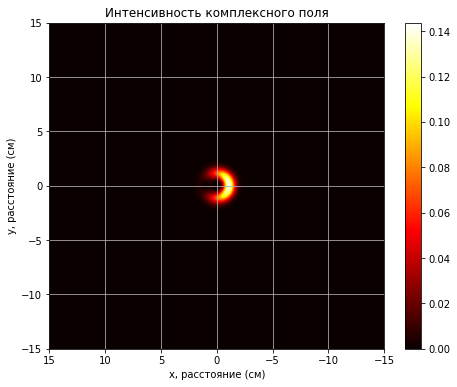

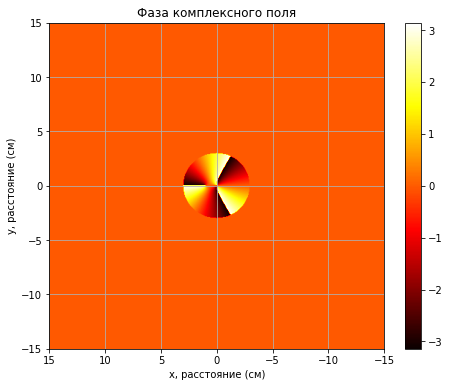

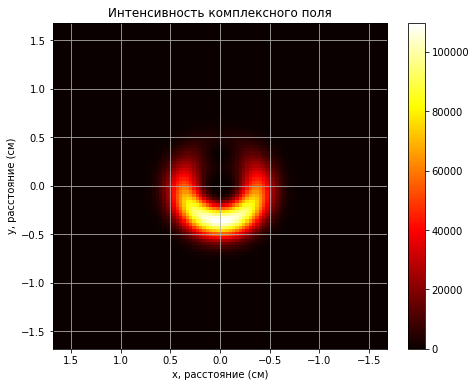

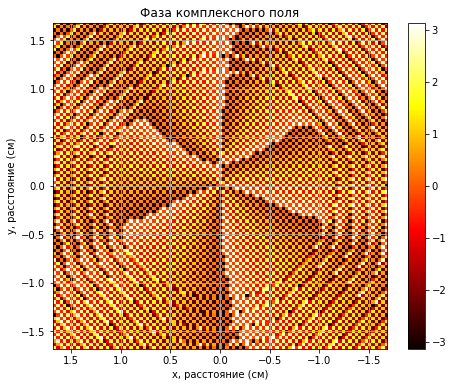

In [10]:
def get_superposition_field_after_tilt_and_fft(a, N, M, m, c, sigma, alpha):
    """
    Дополняет двухмерное изображение нулями до размера new_shape, если new_shape больше размера картини. Обрезает изображение до размера new_shape, если new_shape меньше размера картинки.
    Если по одной оси надо обрезать, а по второй дополнить нулями, выкинется ValueError
    :param a: Размер исходного поля
    :param N: Число отсчётов картинки, поле которой мы генерируем
    :param M: Число отсчётов, до которого дополняем поле до fft2
    :param m: параметр пучка - угловой орбительный момент
    :param c: параметр пучка - угловой орбительный момент
    :param sigma: параметр пучка - радиус перетяжки
    :param alpha: параметр линзы, сквозь который проходит пучок - угол (в радианах) отклонения оси линзы от линии распространения пучка
    :return ((field, x_linspace, y_linspace),(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2))
    """
    b=N*N/4/a/M # 
    print("Размер выходного поля b =",b)

    assert len(m)==len(c) 
    assert sum(c)>=1-1e-8 and sum(c)<=1+1e-8 # Сумма весов должна быть равна 1
    field_superposition = np.zeros((N,N), dtype=field.dtype) # Суперпозиция полей с разных m
    for m_i, c_i in zip(m, c):
        # Генерируем поле лазера
        field_i, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=a, vertex_size=a, matrix_shape=(N, N), m=m_i, sigma=sigma, alpha=alpha)
        field_superposition+=c_i*field_i
    field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros = get_field_padded_zeros(field_superposition, (M, M), x_linspace, y_linspace)
    # Отприсовываем получившееся поле 
    # plot_field(field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)

    # Выполняем fft2 преобразование (+ расщитываем масштаб)
    field_after_fft = np.fft.fft2(field_padded_zeros)
    field_after_fft = np.fft.fftshift(field_after_fft)
    # Отрезаем поле размером NxN
    field_after_fft = get_field_padded_zeros(field_after_fft, (N, N), x_linspace, y_linspace)[0]
    # Перерасчитываем масштаб поля после fft 
    x_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[0])
    y_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[1])
    # Отрисовываем картинки после fft2
    # plot_field(field_after_fft, x_linspace_after_fft, y_linspace_after_fft)
    
    return ((field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros),(field_after_fft, x_linspace_after_fft, y_linspace_after_fft))


(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field_after_tilt_and_fft(a=3, N=101, M=505, m=[2,3], c=[0.5, 0.5], sigma=1, alpha=0.0)
plot_field(field, x_linspace, y_linspace, print_mode=["intensity", "phase"])
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity", "phase"])

### Генерируем и смотрим на разные пучки

Размер выходного поля b = 1.6833333333333333


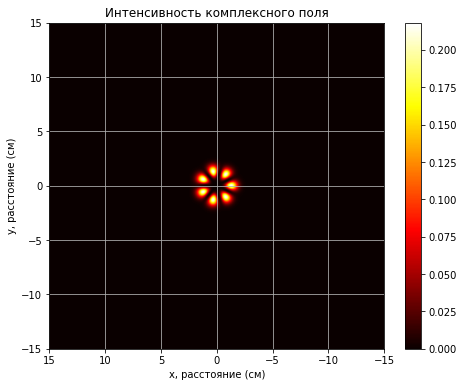

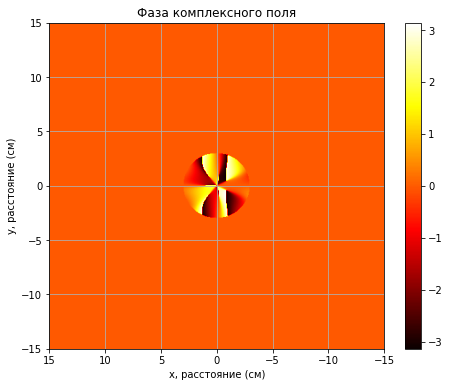

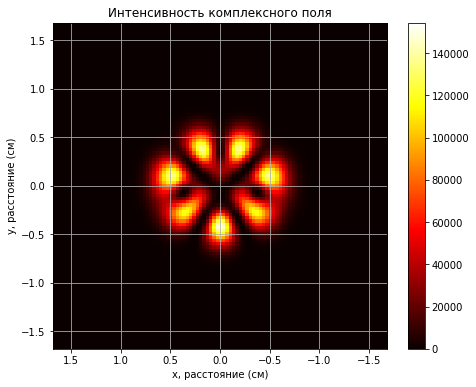

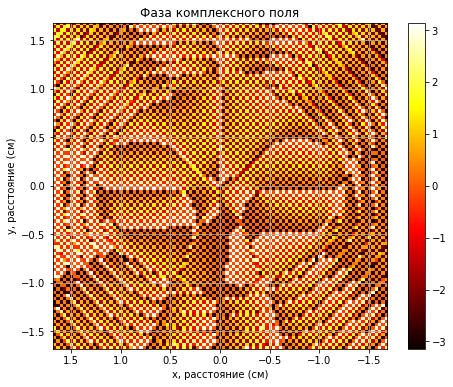

In [11]:

(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field_after_tilt_and_fft(a=3, N=101, M=505, m=[-4,3], c=[0.5, 0.5], sigma=1, alpha=0.5)
plot_field(field, x_linspace, y_linspace, print_mode=["intensity", "phase"])
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity", "phase"])

Размер выходного поля b = 1.6833333333333333


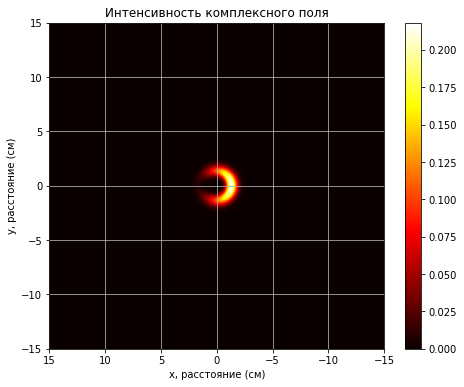

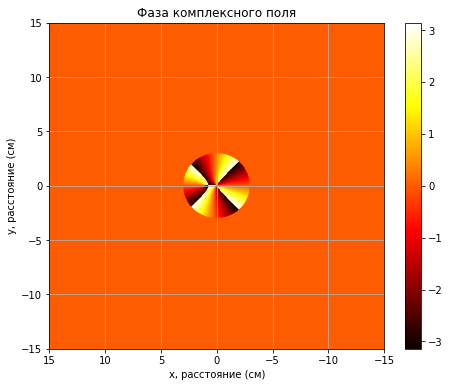

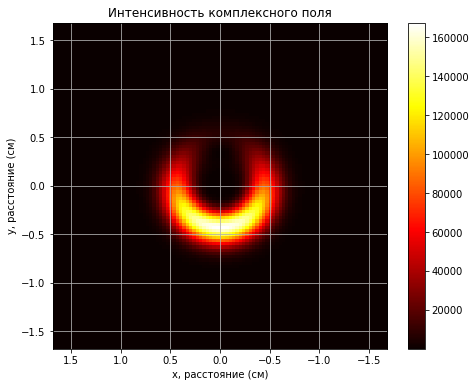

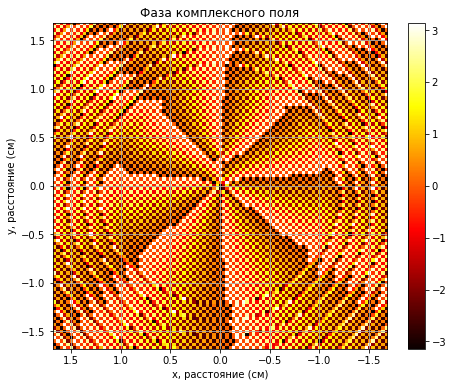

In [12]:
(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field_after_tilt_and_fft(a=3, N=101, M=505, m=[3,4], c=[0.5, 0.5], sigma=1, alpha=0.0)
plot_field(field, x_linspace, y_linspace, print_mode=["intensity", "phase"])
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity", "phase"])

### (Уже неактуально в этом ноутбуке) Реализуем функцию, преобразующую картинку из декартовой системы координат в полярную

In [13]:
# import cv2

In [14]:
# def field_cartesian_to_polar(img, interpolation_mode = cv2.WARP_FILL_OUTLIERS):
#     #--- the following holds the square root of the sum of squares of the image dimensions ---
#     #--- this is done so that the entire width/height of the original image is used to express the complete circular range of the resulting polar image ---
#     # value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0)) # если хотим диагональ картинки взять
#     value = min(img.shape[0]/2.0, img.shape[1]/2.0)
#     polar_image = cv2.linearPolar(img,(img.shape[0]/2, img.shape[1]/2), value, interpolation_mode)
#     return polar_image
    

# polar_image = field_cartesian_to_polar(abs(field))
# plot_field(polar_image, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

In [15]:
# polar_image = field_cartesian_to_polar(abs(field_after_fft2))
# plot_field(polar_image, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

### (Уже неактуально в этом ноутбуке) Убеждаемся, что перевод в полярную систему координат от cv2 корректный

In [16]:


# import skimage

# #image_filename = "https://img3.akspic.ru/previews/3/3/2/7/6/167233/167233-apelsin-nauka-fizika-predvychislenie-matematika-500x.jpg"
# image_filename = "https://cs8.pikabu.ru/post_img/2016/09/11/10/147361593115556395.png"

# image_numpy = skimage.io.imread( image_filename )


# plot_field(image_numpy, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["amplitude"])

# polar_image_numpy = field_cartesian_to_polar(image_numpy)
# plot_field(polar_image_numpy, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["amplitude"])

## (Уже неактуально в этом ноутбуке) Cмотрим на пучки в полярной системе координат

In [17]:
# this_m = [4, 11]
# this_c = [0.3, 0.7]
# this_alpha=0.5
# (field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field_after_tilt_and_fft(a=3, N=101, M=505, m=this_m, c=this_c, sigma=1, alpha=this_alpha)
# #plot_field(field, x_linspace, y_linspace, print_mode=["intensity"])
# plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])
# polar_image = field_cartesian_to_polar(abs(field_after_fft2))
# plot_field(polar_image, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

In [18]:
# this_m = [3, 5]
# this_c = [0.5, 0.5]
# this_alpha=0.0
# (field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field_after_tilt_and_fft(a=3, N=101, M=505, m=this_m, c=this_c, sigma=1, alpha=this_alpha)
# #plot_field(field, x_linspace, y_linspace, print_mode=["intensity"])
# plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])
# polar_image = field_cartesian_to_polar(abs(field_after_fft2))
# plot_field(polar_image, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

# Начнём собирать датасет

#### Берем суперпозиции вихрей с постоянными и равными весам. Величины углового орбитального момента m целые, различные по знакам и лежат в диапазоне [-5, 5]

Размер выходного поля b = 1.6833333333333333


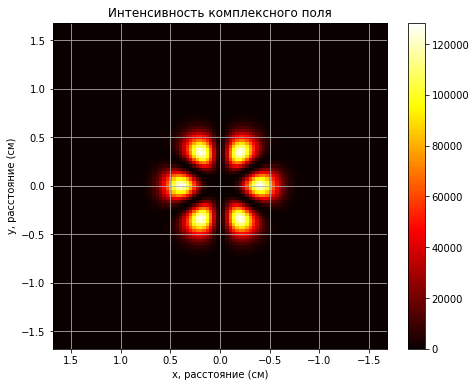

In [19]:
this_m = [-3, 3]
this_c = [0.5, 0.5]
this_alpha=0.0
(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field_after_tilt_and_fft(a=3, N=101, M=505, m=this_m, c=this_c, sigma=1, alpha=this_alpha)
# plot_field(field, x_linspace, y_linspace, print_mode=["intensity"])
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

Размер выходного поля b = 1.6833333333333333


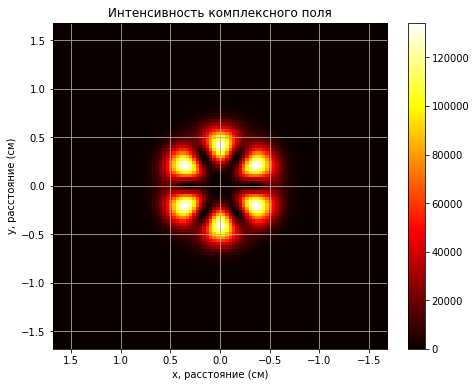

In [20]:
this_m = [-4, 2]
this_c = [0.5, 0.5]
this_alpha=0.0
(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field_after_tilt_and_fft(a=3, N=101, M=505, m=this_m, c=this_c, sigma=1, alpha=this_alpha)
#plot_field(field, x_linspace, y_linspace, print_mode=["intensity"])
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

Размер выходного поля b = 1.0826732673267327


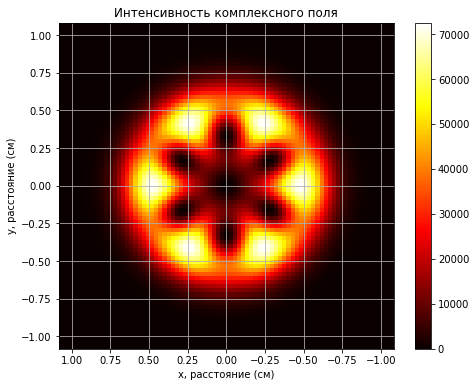

In [21]:
this_m = [-5, 1]
this_c = [0.5, 0.5]
this_alpha=0.0
(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field_after_tilt_and_fft(a=3, N=81, M=505, m=this_m, c=this_c, sigma=1, alpha=this_alpha)
#plot_field(field, x_linspace, y_linspace, print_mode=["intensity"])
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

#### **Сгенерируем выборку в несколько классов и формируем массив изображений и их метки**

In [22]:
image_shape=81
beam_images=[]
beam_label=[]

counter_pictures=0
for i in range(0,6): #0..5
    for j in range(-5,0): #-5..-1
        for c1 in [0.4, 0.5, 0.6]:
            counter_pictures+=1
            print("|m1-m2| =", i-j, "\tm1 =", i, "m2 =", j, "\tc1=", c1, "c2=", 1-c1)
            this_m = [i, j]
            (field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field_after_tilt_and_fft(a=3, N=image_shape, M=505, m=this_m, c=[c1, 1-c1], sigma=1, alpha=0.0)
            #plot_field(field, x_linspace, y_linspace, print_mode=["intensity"])
            field_after_fft2 = abs(field_after_fft2)
            beam_images.append(field_after_fft2[np.newaxis, ...])
            beam_label.append([i-j,i,j,c1,1-c1])
            
            #!plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])
        
        
beam_images=np.concatenate(beam_images, axis=0)
beam_images.shape

|m1-m2| = 5 	m1 = 0 m2 = -5 	c1= 0.4 c2= 0.6
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 5 	m1 = 0 m2 = -5 	c1= 0.5 c2= 0.5
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 5 	m1 = 0 m2 = -5 	c1= 0.6 c2= 0.4
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 4 	m1 = 0 m2 = -4 	c1= 0.4 c2= 0.6
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 4 	m1 = 0 m2 = -4 	c1= 0.5 c2= 0.5
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 4 	m1 = 0 m2 = -4 	c1= 0.6 c2= 0.4
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 3 	m1 = 0 m2 = -3 	c1= 0.4 c2= 0.6
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 3 	m1 = 0 m2 = -3 	c1= 0.5 c2= 0.5
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 3 	m1 = 0 m2 = -3 	c1= 0.6 c2= 0.4
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 2 	m1 = 0 m2 = -2 	c1= 0.4 c2= 0.6
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 2 	m1 = 0 m2 = -2 	c1= 0.5 c2= 0.5
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 

(90, 81, 81)

[2, 1, -1, 0.6, 0.4]


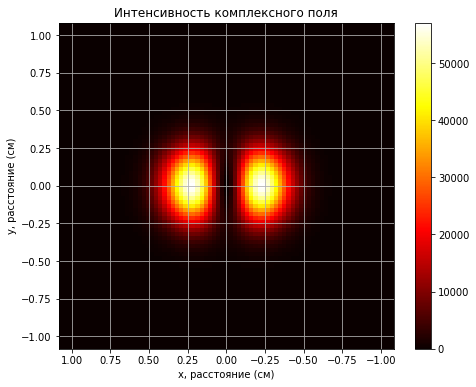

In [23]:
print(beam_label[29])
plot_field(beam_images[29], x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

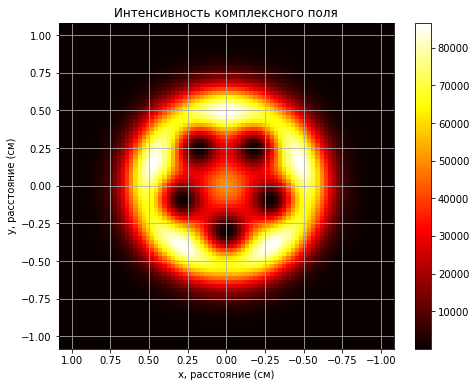

In [24]:
plot_field(beam_images[0], x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

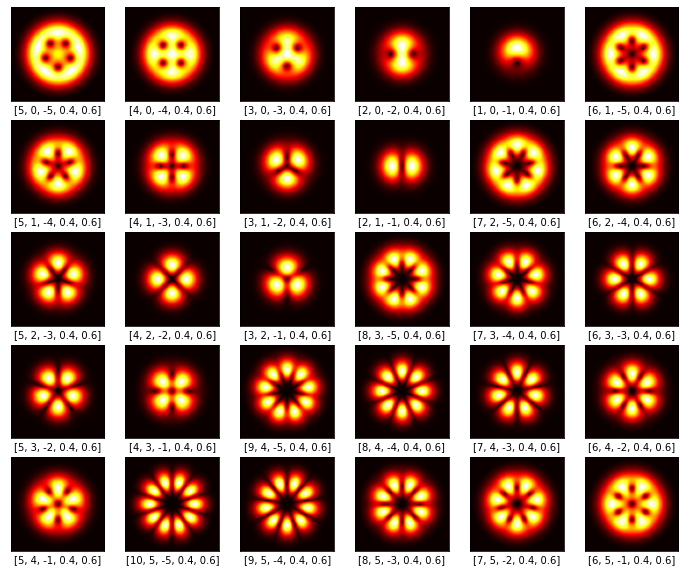

In [25]:
plt.figure(figsize=(12,10))
for i in range(30):
    plt.subplot(5,6,i+1) # индексы тут и в figure наоборот, как ни странно
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(beam_images[3*i], cmap=plt.cm.hot)
#     plt.xlabel(class_names[beam_label[i]])
    plt.xlabel(beam_label[3*i])


In [26]:
beam_label

[[5, 0, -5, 0.4, 0.6],
 [5, 0, -5, 0.5, 0.5],
 [5, 0, -5, 0.6, 0.4],
 [4, 0, -4, 0.4, 0.6],
 [4, 0, -4, 0.5, 0.5],
 [4, 0, -4, 0.6, 0.4],
 [3, 0, -3, 0.4, 0.6],
 [3, 0, -3, 0.5, 0.5],
 [3, 0, -3, 0.6, 0.4],
 [2, 0, -2, 0.4, 0.6],
 [2, 0, -2, 0.5, 0.5],
 [2, 0, -2, 0.6, 0.4],
 [1, 0, -1, 0.4, 0.6],
 [1, 0, -1, 0.5, 0.5],
 [1, 0, -1, 0.6, 0.4],
 [6, 1, -5, 0.4, 0.6],
 [6, 1, -5, 0.5, 0.5],
 [6, 1, -5, 0.6, 0.4],
 [5, 1, -4, 0.4, 0.6],
 [5, 1, -4, 0.5, 0.5],
 [5, 1, -4, 0.6, 0.4],
 [4, 1, -3, 0.4, 0.6],
 [4, 1, -3, 0.5, 0.5],
 [4, 1, -3, 0.6, 0.4],
 [3, 1, -2, 0.4, 0.6],
 [3, 1, -2, 0.5, 0.5],
 [3, 1, -2, 0.6, 0.4],
 [2, 1, -1, 0.4, 0.6],
 [2, 1, -1, 0.5, 0.5],
 [2, 1, -1, 0.6, 0.4],
 [7, 2, -5, 0.4, 0.6],
 [7, 2, -5, 0.5, 0.5],
 [7, 2, -5, 0.6, 0.4],
 [6, 2, -4, 0.4, 0.6],
 [6, 2, -4, 0.5, 0.5],
 [6, 2, -4, 0.6, 0.4],
 [5, 2, -3, 0.4, 0.6],
 [5, 2, -3, 0.5, 0.5],
 [5, 2, -3, 0.6, 0.4],
 [4, 2, -2, 0.4, 0.6],
 [4, 2, -2, 0.5, 0.5],
 [4, 2, -2, 0.6, 0.4],
 [3, 2, -1, 0.4, 0.6],
 [3, 2, -1,

### Выясним сбалансированность данных 

In [27]:
tmp_beam_label = []
for i,_,_,_,_ in beam_label:
    tmp_beam_label.append(i)
tmp_beam_label


for i in set(tmp_beam_label):
    print(i,"\t", tmp_beam_label.count(i))


1 	 3
2 	 6
3 	 9
4 	 12
5 	 15
6 	 15
7 	 12
8 	 9
9 	 6
10 	 3


мб было бы логичным выкинуть картинки с постоянным |m1-m2|, у которых мало различных уникальных картинок, но это потом

### **Аугментация данных**

### Аугментация поворотом:

Реализуем поворот из статьи https://arboook.com/kompyuternoe-zrenie/osnovnye-operatsii-s-izobrazheniyami-v-opencv-3-python/

Протестируем код на одной картинке:

Text(0.5, 0, '[4, 0, -4, 0.4, 0.6]')

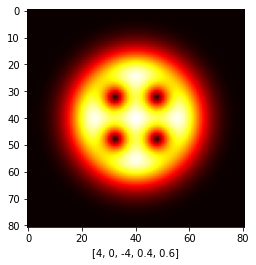

In [28]:
plt.imshow(beam_images[3], cmap=plt.cm.hot)
plt.xlabel(beam_label[3])

In [29]:
for angle in np.linspace(0,360,6, endpoint=False):
    print(angle)

0.0
60.0
120.0
180.0
240.0
300.0


In [30]:
import cv2

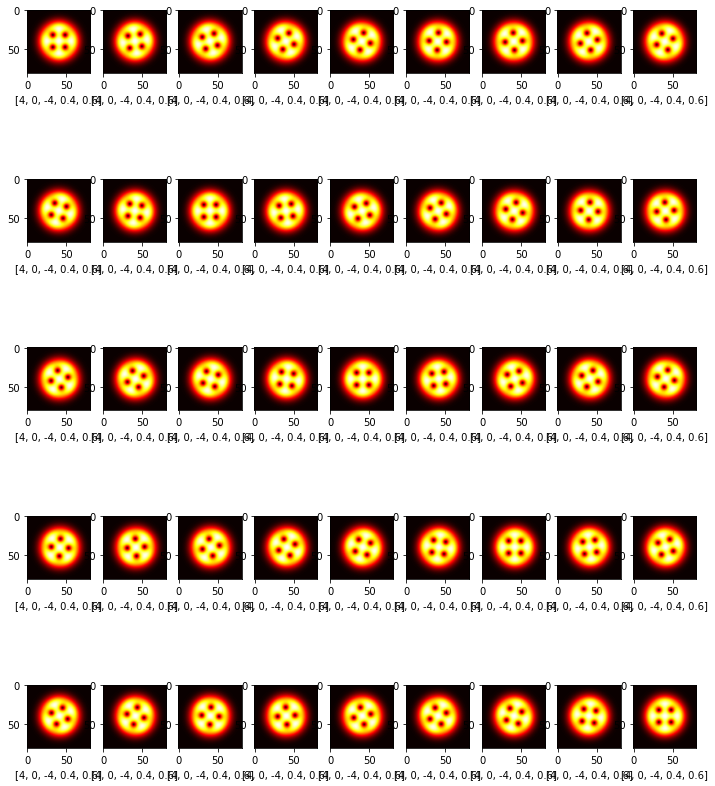

In [31]:
plt.figure(figsize=(12,15))
for index, angle in enumerate(np.linspace(0,360,45)):
    plt.subplot(5,9,index+1)
    image = beam_images[3]
    #получим размеры изображения для поворота
    # и вычислим центр изобрафжения
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)

    # повернем изображение на angle градусов
    # todo можно 
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))

    plt.imshow(rotated, cmap=plt.cm.hot)
    plt.xlabel(beam_label[3])
    

Обобщим код и обернем в функцию:






In [32]:
def angle_augmentation(image, label = None, num = 30, plot=False):
    """
    Функция поворачивает картинку на углы из np.linspace(0, 360, num, endpoint=False)
    Т.е. 360 градусов разбивается на num отсчётов. И каждая картинка будет повернута на величину этого отсчёта
    :param image: Исходное изображение
    :param label: Необязательная подпись к изображению, которая отобразится на рисунке, если параметр plot=True
    :param num: Количество изображений, которые будут сгенерированы. Число 
    :param plot: Булевый параметр, если True, то каждое вычисленное изображение будет выведено на экран. Если False, то ничего не будет выводиться
    :return Возвращает массив из num изображений, каждая из которых повернута  вокруг центра изображения
    """
    result_rotated = []
    if plot:
        plt.figure(figsize=(12,15))
    for index, angle in enumerate(np.linspace(0, 360, num, endpoint=False)):
        if plot:
            plt.subplot(5, math.ceil(num/5),index+1)
        #получим размеры изображения для поворота
        # и вычислим центр изображения
        (h, w) = image.shape[:2]
        center = (w / 2, h / 2)

        # повернем изображение на angle градусов
        # todo: можно рандом в поворот вкрячить ещё
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        if plot:
            plt.imshow(rotated, cmap=plt.cm.hot)
            plt.xlabel(label)
        result_rotated.append(rotated[np.newaxis, ...])
    
    result_rotated=np.concatenate(result_rotated, axis=0)
    return result_rotated
    
tmp_11=angle_augmentation(beam_images[9], beam_label[9], num=12)
tmp_11.shape

(12, 81, 81)

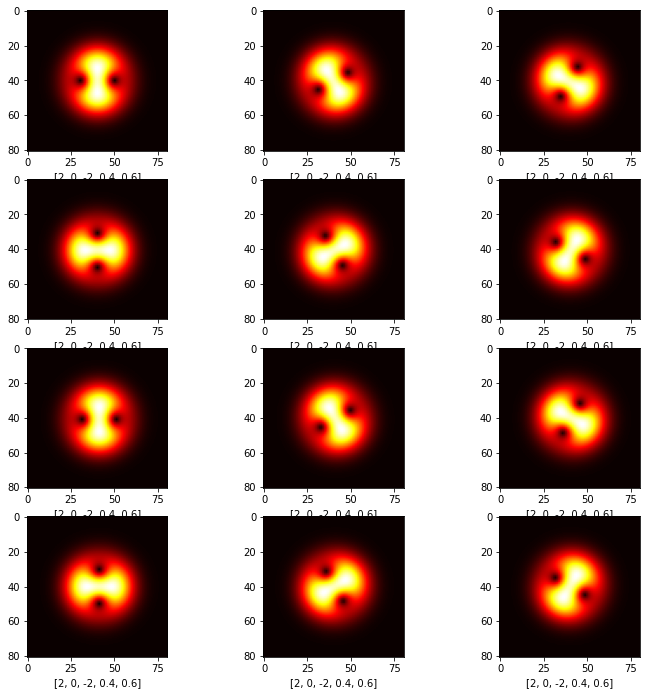

In [33]:
tmp_12=angle_augmentation(beam_images[9], beam_label[9], num=12, plot=True)

In [34]:
after_angular_images = np.zeros(shape=(0, beam_images.shape[1], beam_images.shape[2]))
for image, label in zip(beam_images, beam_label): # идём по каждой картинке
    result_angle_augmentation = angle_augmentation(image, label, num=12)
    after_angular_images = np.concatenate((after_angular_images, result_angle_augmentation), axis=0)
    # print(result_angle_augmentation.shape)
after_angular_images.shape

(1080, 81, 81)

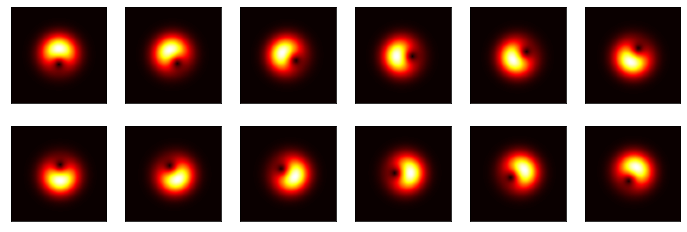

In [35]:
plt.figure(figsize=(12,4))
for i in range(12):
    plt.subplot(2,6,i+1) # индексы тут и в figure наоборот, как ни странно
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(after_angular_images[i+36*4], cmap=plt.cm.hot)


todo: Полученные изображения можно ещё масштабировать(такое может быть, если добавили линзу), добавлять шум

### Аугментация сдвигом

Протестируем код на одной картинке:

Text(0.5, 0, '[4, 0, -4, 0.4, 0.6]')

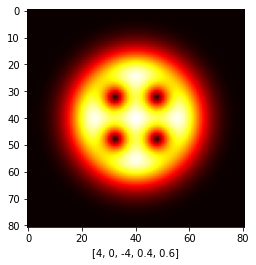

In [36]:
plt.imshow(beam_images[3], cmap=plt.cm.hot)
plt.xlabel(beam_label[3])

Text(0.5, 0, '[4, 0, -4, 0.4, 0.6]')

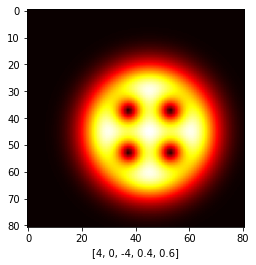

In [37]:
image = beam_images[3]
#получим размеры изображения для поворота
# и вычислим центр изобрафжения
(h, w) = image.shape[:2]
# сдвинем изображение

(width_shift, height_shift) = (5, 5)
shifting_matrix = np.array([[1,0,width_shift],[0,1,height_shift]], dtype=np.float64)
shifted_image = cv2.warpAffine(image, shifting_matrix, (w, h))

plt.imshow(shifted_image, cmap=plt.cm.hot)
plt.xlabel(beam_label[3])

Обобщим код и обернем в функцию:

(2, 81, 81)

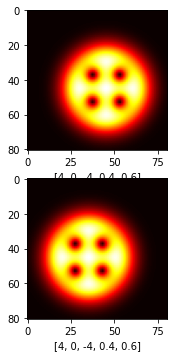

In [38]:
def shift_augmentation(image, label = None, image_shift_array=[(0,0)], plot=False):
    """
    Функция сдвигает картинку и возвращает массив изображений, сдвинутых на величину image_shift_array
    :param image: Исходное изображение
    :param label: Необязательная подпись к изображению, которая отобразится на рисунке, если параметр plot=True
    :param image_shift_array: список из кортежей, первой число в кортеже отвечает за сдвиг изображения по горизонтальной оси, а второе число за сдвиг по вертикальной оси
    :param plot: Булевый параметр, если True, то каждое высичленное изображение будет выведено на экран. Если False, то ничего не будет выводиться
    :return возвращает массив изображений, каждая из которых сдвинута на соответствующую величину из image_shift_array
    """
    assert len(image.shape) == 2
    
    result_shifted = []
    if plot:
        plt.figure(figsize=(12,15))
    for index, image_shift in enumerate(image_shift_array):
        if plot:
            plt.subplot(5, math.ceil(len(image_shift_array)/5),index+1)
        #получим размеры изображения для поворота
        (h, w) = image.shape[:2]

        # сдвинем изображение
        # todo: можно рандом в сдвиг вкрячить ещё
        (width_shift, height_shift) = image_shift
        shifting_matrix = np.array([[1, 0, width_shift], [0, 1, height_shift]], dtype=np.float64)
        shifted_image = cv2.warpAffine(image, shifting_matrix, (w, h))
        if plot:
            plt.imshow(shifted_image, cmap=plt.cm.hot)
            plt.xlabel(label)
        result_shifted.append(shifted_image[np.newaxis, ...])
        # todo: не забыть индексы пересчитать тут
    
    result_rotated=np.concatenate(result_shifted, axis=0)
    return result_rotated
    
tmp_15=shift_augmentation(beam_images[3], beam_label[3], image_shift_array=[(5,5), (-5,5)], plot=True)
tmp_15.shape

Эмпирически определим маскимальное количество пикселей, на которое можно сдвинуть самый "широкий" пучок, чтобы он не уходил за пределы окна изображения.

(2, 81, 81)

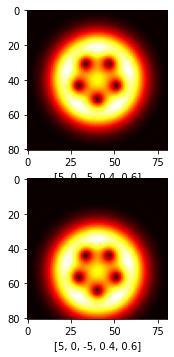

In [39]:
tmp_15=shift_augmentation(beam_images[0], beam_label[0], image_shift_array=[(0,0), (0,13)], plot=True)
tmp_15.shape

У нас получилось 13/81≈1/6. Именно таким далее в коде и возьмем значение перемнной `scale`

Генерируем массив сдвигов, который будем скармливать в `shift_augmentation()`

In [40]:
def generate_shift_array(image, scale = 1/6, step = 2):
  """
  Генерируем массив кортежей, которые представляют декартово произведение из возможных сдвигов на изображения на scale процентов по горизонтальной и вертикальной оси
  Ну, массив координат сетки с числами, на сколько надо сдвигать изображение.
  Вся эта функция написана ради того, чтобы сдвиги были целыми числами
  :param image: Исходное изображение
  :param scale: На какой процент от изображения можно маскимально сдвигать изображение
  :param step: 
  """
  assert len(image.shape) == 2
  
  max_width_shift_value = int(scale * image.shape[0])  # по картинке эмпирически подобрали максимальную величину сдвига. Чтобы не пучок не вылетал за границы икна изображения
  max_width_shift_value = max_width_shift_value // 2 * 2  # округляем до ближайшего снизу числа, делящегося на два. Для того чтобы в range(-max_width_shift_value, max_width_shift_value + 1, 2) был значение ноль
  # print("max_width_shift_value =", max_width_shift_value)
  width_range = range(-max_width_shift_value, max_width_shift_value + 1, step)

  max_height_shift_value = int(scale * image.shape[1])  # по картинке эмпирически подобрали максимальную величину сдвига. Чтобы не пучок не вылетал за границы икна изображения
  max_height_shift_value = max_height_shift_value // 2 * 2  # округляем до ближайшего снизу числа, делящегося на два. Для того чтобы в range(-max_height_shift_value, max_height_shift_value + 1, 2) был значение ноль
  # print("max_height_shift_value =", max_height_shift_value)
  height_range = range(-max_height_shift_value, max_height_shift_value + 1, step)

  i_coords, j_coords = np.meshgrid(width_range, height_range)
  return np.vstack((i_coords.flatten(), j_coords.flatten())).T

image_shift_array_tmp = generate_shift_array(beam_images[3])
print("image_shift_array_tmp.shape =", image_shift_array_tmp.shape)
image_shift_array_tmp[:5] # Первые пять элементов

image_shift_array_tmp.shape = (169, 2)


array([[-12, -12],
       [-10, -12],
       [ -8, -12],
       [ -6, -12],
       [ -4, -12]])

 Протестируем аугментацию сдвигом, описанную в методах `shift_augmentation()` и `generate_shift_array()` на одной тестовой картинке

In [41]:
# решил взять scale=1/8, step = 8 чтобы было сфорировано 9 изображений, а не 25 как при scale=1/6, step = 6
image_shift_array_test2 = generate_shift_array(beam_images[3], scale=1/8, step = 8)
len(image_shift_array_test2)

9

(9, 81, 81)

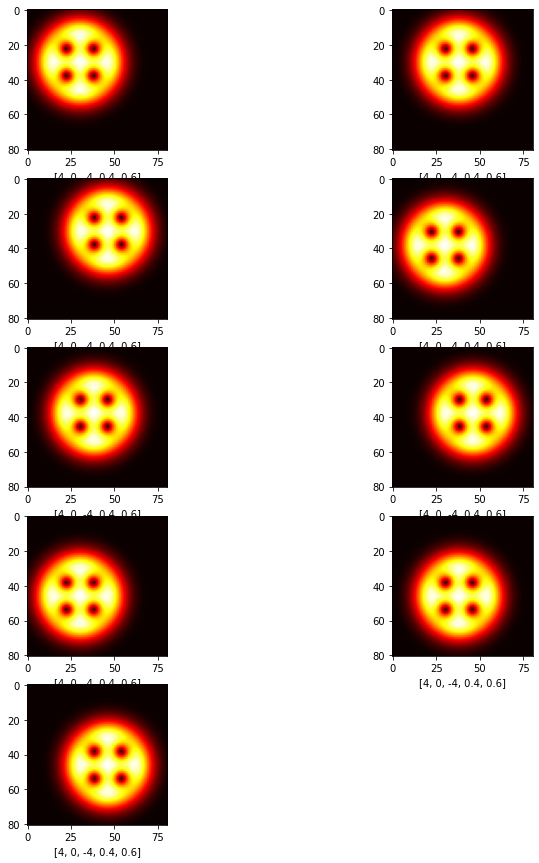

In [42]:
tmp_15=shift_augmentation(beam_images[3], beam_label[3], image_shift_array=image_shift_array_test2, plot=True)
tmp_15.shape

#### **Объединим вышеприведенные аументации поворотом и сдвигом:**

In [43]:
def make_shift_aumentation_for_array(beam_images, beam_labels):

  after_angular_images = np.zeros(shape=(0, beam_images.shape[1], beam_images.shape[2]))
  after_angular_labels = np.zeros(shape=(0, 5))
  counter_pictures=0
  for image, label in zip(beam_images, beam_labels): # идём по каждой картинке
      assert type(label) is list, "Если label не list, то некорректно произойдет склеивание меток несколькими строчками кода ниже"
      result_angle_augmentation = angle_augmentation(image, label, num=12)
      after_angular_images = np.concatenate((after_angular_images, result_angle_augmentation), axis=0)  # склеиваем картинки вместе
      after_angular_labels = np.concatenate((after_angular_labels, [label]*len(result_angle_augmentation)), axis=0)  # склеиваем метки картинок вместе
      counter_pictures+=1
      if counter_pictures % 10 == 0:
        print("counter_pictures=", counter_pictures, "\tafter_angular_images.shape =", after_angular_images.shape, "\tи after_angular_labels.shape =", after_angular_labels.shape)
  return (after_angular_images, after_angular_labels)

after_angular_images, after_angular_labels = make_shift_aumentation_for_array(beam_images, beam_label)

counter_pictures= 10 	after_angular_images.shape = (120, 81, 81) 	и after_angular_labels.shape = (120, 5)
counter_pictures= 20 	after_angular_images.shape = (240, 81, 81) 	и after_angular_labels.shape = (240, 5)
counter_pictures= 30 	after_angular_images.shape = (360, 81, 81) 	и after_angular_labels.shape = (360, 5)
counter_pictures= 40 	after_angular_images.shape = (480, 81, 81) 	и after_angular_labels.shape = (480, 5)
counter_pictures= 50 	after_angular_images.shape = (600, 81, 81) 	и after_angular_labels.shape = (600, 5)
counter_pictures= 60 	after_angular_images.shape = (720, 81, 81) 	и after_angular_labels.shape = (720, 5)
counter_pictures= 70 	after_angular_images.shape = (840, 81, 81) 	и after_angular_labels.shape = (840, 5)
counter_pictures= 80 	after_angular_images.shape = (960, 81, 81) 	и after_angular_labels.shape = (960, 5)
counter_pictures= 90 	after_angular_images.shape = (1080, 81, 81) 	и after_angular_labels.shape = (1080, 5)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


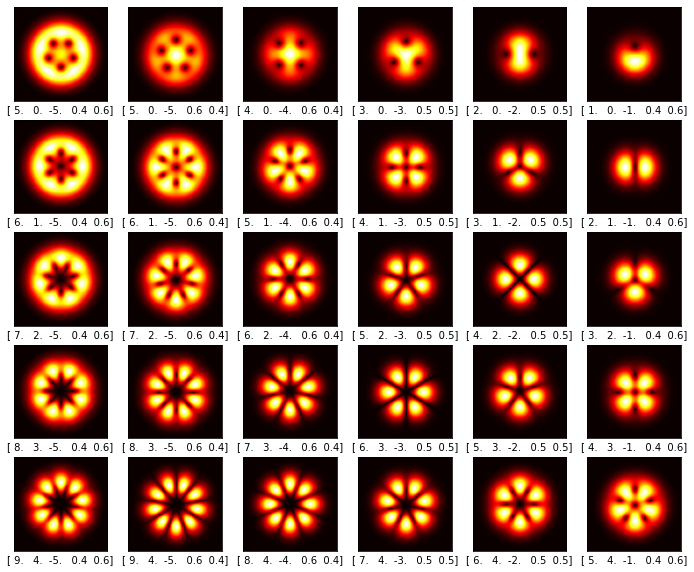

In [44]:
plt.figure(figsize=(12,10))
for i in range(30):
    plt.subplot(5,6,i+1) # индексы тут и в figure наоборот, как ни странно
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(after_angular_images[i*30], cmap=plt.cm.hot)
    plt.xlabel(after_angular_labels[i*30])


In [45]:
def make_shift_aumentation_for_array(beam_images, beam_labels):

  after_angular_and_shift_images = np.zeros(shape=(0, beam_images.shape[1], beam_images.shape[2]))
  after_angular_and_shift_labels = np.zeros(shape=(0, 5))
  image_shift_array_tmp = generate_shift_array(beam_images[0], scale=1/6, step = 6) # далее меняться не будет
  counter_pictures=0
  for image, label in zip(beam_images, beam_labels): # идём по каждой картинке
      # аугментация сдвигом
      result_shift_augmentation = shift_augmentation(image, label, image_shift_array=image_shift_array_tmp)
      after_angular_and_shift_images = np.concatenate((after_angular_and_shift_images, result_shift_augmentation), axis=0)  # склеиваем картинки вместе
      after_angular_and_shift_labels = np.concatenate((after_angular_and_shift_labels, [label]*len(result_shift_augmentation)), axis=0)  # склеиваем метки картинок вместе
      counter_pictures+=1
      if counter_pictures % 50 == 0:
        print("counter_pictures=", counter_pictures, "\tafter_angular_and_shift_images.shape =", after_angular_and_shift_images.shape, "\tи after_angular_and_shift_labels.shape =", after_angular_and_shift_labels.shape)
  return (after_angular_and_shift_images, after_angular_and_shift_labels)


after_angular_and_shift_images, after_angular_and_shift_labels = make_shift_aumentation_for_array(after_angular_images, after_angular_labels)

counter_pictures= 50 	after_angular_and_shift_images.shape = (1250, 81, 81) 	и after_angular_and_shift_labels.shape = (1250, 5)
counter_pictures= 100 	after_angular_and_shift_images.shape = (2500, 81, 81) 	и after_angular_and_shift_labels.shape = (2500, 5)
counter_pictures= 150 	after_angular_and_shift_images.shape = (3750, 81, 81) 	и after_angular_and_shift_labels.shape = (3750, 5)
counter_pictures= 200 	after_angular_and_shift_images.shape = (5000, 81, 81) 	и after_angular_and_shift_labels.shape = (5000, 5)
counter_pictures= 250 	after_angular_and_shift_images.shape = (6250, 81, 81) 	и after_angular_and_shift_labels.shape = (6250, 5)
counter_pictures= 300 	after_angular_and_shift_images.shape = (7500, 81, 81) 	и after_angular_and_shift_labels.shape = (7500, 5)
counter_pictures= 350 	after_angular_and_shift_images.shape = (8750, 81, 81) 	и after_angular_and_shift_labels.shape = (8750, 5)
counter_pictures= 400 	after_angular_and_shift_images.shape = (10000, 81, 81) 	и after_angular_and

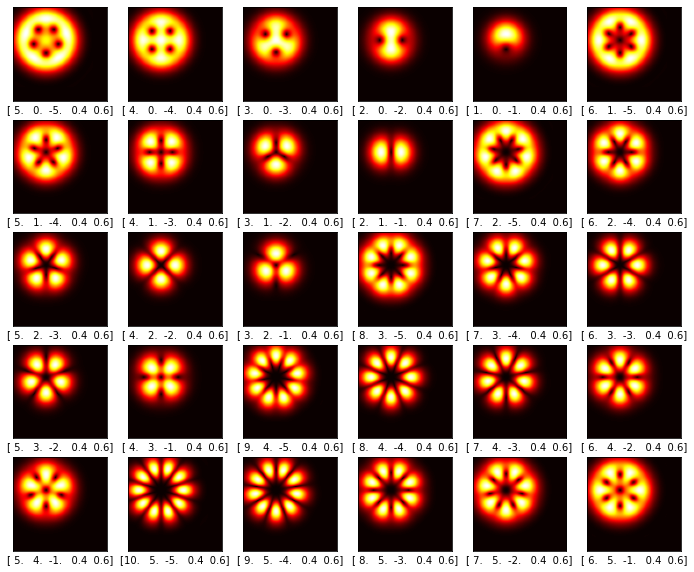

In [133]:
plt.figure(figsize=(12,10))
for i in range(30):
    plt.subplot(5,6,i+1) # индексы тут и в figure наоборот, как ни странно
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(after_angular_and_shift_images[i*900], cmap=plt.cm.hot)
    plt.xlabel(after_angular_and_shift_labels[i*900])


### **Сохраняем полученные изображения в файл**

In [47]:
import pickle

In [48]:
with open('after_angular_and_shift_images.pkl','wb') as file_images:
  pickle.dump(after_angular_and_shift_images, file_images)

In [49]:
# np.savetxt('after_angular_and_shift_labels.csv', after_angular_and_shift_labels, delimiter=',')
with open('after_angular_and_shift_labels.pkl','wb') as file_images:
  pickle.dump(after_angular_and_shift_labels, file_images)

### **Проверяем результат сохранения в файл:**

In [50]:
beam_label[3]

[4, 0, -4, 0.4, 0.6]

In [51]:
after_angular_and_shift_labels[0]

array([ 5. ,  0. , -5. ,  0.4,  0.6])

In [52]:
with open('after_angular_and_shift_images.pkl', 'rb') as file_images_read:
  images_new_raw = pickle.load(file_images_read)

In [53]:
with open('after_angular_and_shift_labels.pkl', 'rb') as file_labels_read:
  labels_new = pickle.load(file_labels_read).astype(int)  # дополнительно приводим к целим значениям

Нормализовываем каждое изображение (чтобы значение пикселя было в диапазоне [0, 1]):

In [54]:
images_new_raw.shape

(27000, 81, 81)

In [55]:
images_new = images_new_raw.copy()
for index, one_image in enumerate(images_new_raw):
  images_new[index] = one_image / np.max(one_image)

del(images_new_raw) # очищаем большую переменную

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


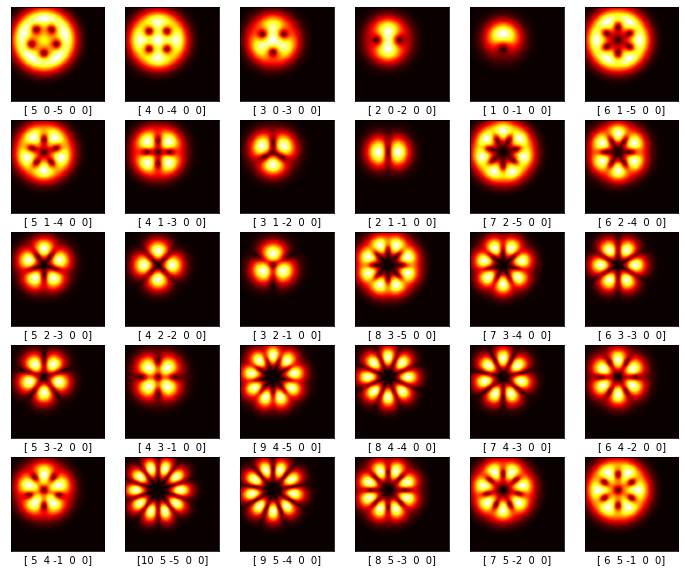

In [132]:
plt.figure(figsize=(12,10))
for i in range(30):
    plt.subplot(5,6,i+1) # индексы тут и в figure наоборот, как ни странно
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_new[i*900], cmap=plt.cm.hot)
    plt.xlabel(labels_new[i*900])


### Готовим данные на train и test:

In [57]:
images_new.shape

(27000, 81, 81)

In [58]:
labels_new.shape

(27000, 5)

In [59]:
from sklearn.model_selection import train_test_split

data, labels = np.arange(10).reshape((5, 2)), range(5)

data_train, data_test, labels_train_raw, labels_test_raw = train_test_split(images_new, labels_new, test_size=0.20, random_state=42)

In [60]:
labels_train_raw[0]

array([ 7,  3, -4,  0,  0])

In [61]:
# отбросим лишние данные из массивов labels и делаем их целочисленными в диапазоне [0,9]
labels_train = labels_train_raw[:,0] - 1
labels_test = labels_test_raw[:,0] - 1

del(labels_train_raw) # очищаем переменную
del(labels_test_raw) # очищаем переменную

labels_train

array([6, 5, 3, ..., 4, 5, 8])

In [62]:
class_names = [1,2,3,4,5,6,7,8,9,10] # маппинг ответов нейронки на реальное значение модуля разницы между угловыми орбитальными моментами двух пучков в их суперпозиции. Т.е. если нейронка выдаёт 0, то действительная разницы угловых орб моментов равна 1

Посмотрим на первые 30 изображений после разбиения на train и test и после шафлинга:

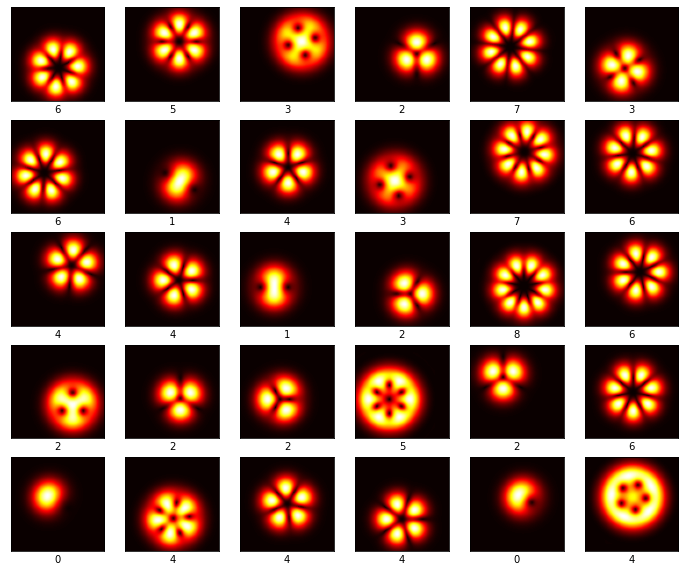

In [63]:
plt.figure(figsize=(12,10))
for i in range(30):
    plt.subplot(5,6,i+1) # индексы тут и в figure наоборот, как ни странно
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_train[i], cmap=plt.cm.hot)
    plt.xlabel(labels_train[i])


### Далее при обучении модели воспроизводим статью https://habr.com/ru/post/426797/

In [64]:
#Подключаем библиотеки
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

### **Строим модель**

In [122]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(81, 81)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

### **Компилируем модель**

In [123]:
model.compile(optimizer=tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [124]:
history = model.fit(data_train, labels_train, validation_split=0.33, epochs=25)

Epoch 1/25
453/453 [==============================] - 7s 14ms/step - loss: 1.5314 - accuracy: 0.3497 - val_loss: 1.2797 - val_accuracy: 0.4367
Epoch 2/25
453/453 [==============================] - 6s 14ms/step - loss: 1.1133 - accuracy: 0.4852 - val_loss: 1.0918 - val_accuracy: 0.5037
Epoch 3/25
453/453 [==============================] - 6s 13ms/step - loss: 1.0017 - accuracy: 0.5255 - val_loss: 1.0468 - val_accuracy: 0.5190
Epoch 4/25
453/453 [==============================] - 5s 11ms/step - loss: 0.9328 - accuracy: 0.5533 - val_loss: 0.9374 - val_accuracy: 0.5507
Epoch 5/25
453/453 [==============================] - 6s 13ms/step - loss: 0.8805 - accuracy: 0.5790 - val_loss: 0.9101 - val_accuracy: 0.5605
Epoch 6/25
453/453 [==============================] - 5s 11ms/step - loss: 0.8548 - accuracy: 0.5883 - val_loss: 0.8824 - val_accuracy: 0.5565
Epoch 7/25
453/453 [==============================] - 6s 13ms/step - loss: 0.8223 - accuracy: 0.6071 - val_loss: 0.8739 - val_accuracy: 0.5615

In [125]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

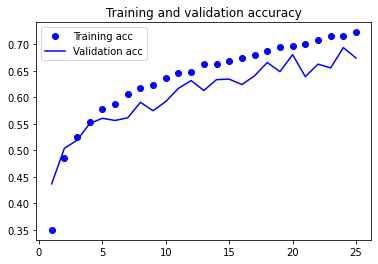

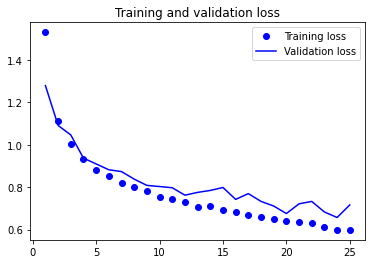

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [90]:
test_loss, test_acc = model.evaluate(data_test, labels_test)
print('Test accuracy:', test_acc)

169/169 [==============================] - 1s 4ms/step - loss: 0.2997 - accuracy: 0.8833
Test accuracy: 0.8833333253860474


#### **Вывод: Среднее значение accuracy (точности) на обучающей и тестовой выборке - 0,88. Что хороший результат без переобучений на данной простой нейронной сети**

### Прогнозирование



In [127]:
predictions = model.predict(data_test)

169/169 [==============================] - 1s 4ms/step


In [128]:
np.argmax(predictions[0])

4

Напишем функции для визуализации предсказаний

In [129]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.hot)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("pred={}, prob={:2.0f}%, (real={})".format(class_names[predicted_label],
                              100*np.max(predictions_array),
                              class_names[true_label]),
                              color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

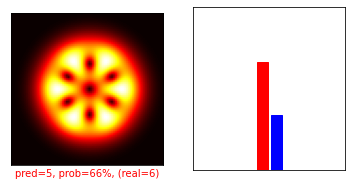

In [130]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, labels_test, data_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  labels_test)

### Посмотрим на результат предсказаний:

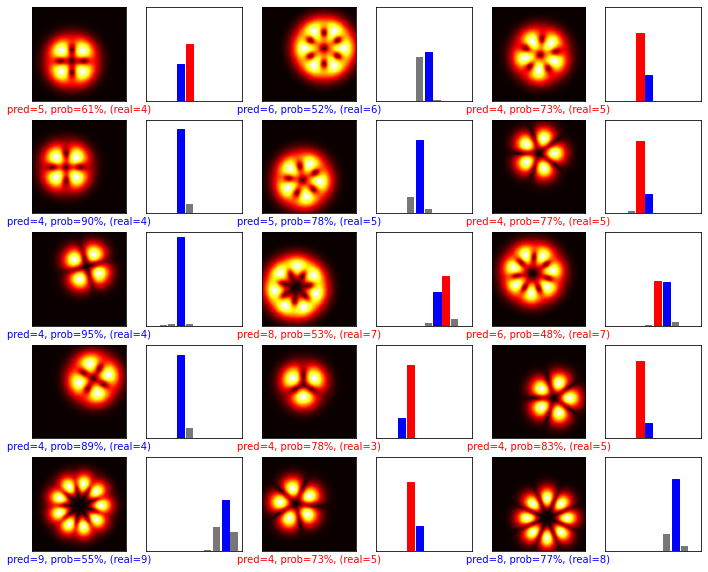

In [131]:
num_rows = 5
num_cols = 3
start_index = 50 # Начиная с этого индекса смотрим на картинки
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i + start_index, predictions, labels_test, data_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i + start_index, predictions,  labels_test)